# SM from IRRmodel into WCM, both with PSO on KGE

The v2 code provides integration of IRRmodel inside WCM.
The simulated SM from IRRmodel is inserted inside WCM as the SM input and A,B,C,D parameters of the latter model are calibrated together with the other parameters of IRRmodel.

In [1]:
# Base
import os
import re
import time
import math
import numpy as np
import pandas as pd
import datetime as dtt

# Analysis
import pyswarms as ps
from scipy import special as sp
from scipy.optimize import curve_fit
from numpy.polynomial import Polynomial
from scipy.signal import savgol_filter as sfilter

# Geospatial
# import fiona
import xarray as xr
import hydroeval as he
# import geopandas as gpd
# from maps_original import *

# Graphics
import seaborn as sns
import matplotlib as mplt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pyswarms.utils.plotters import plot_cost_history
from pyswarms.utils.functions.single_obj import sphere

In [2]:
# Ausiliary functions

#-----------------------------------------------------------------------------

def lin_db(x):
    return 10*np.log10(x)

def db_lin(x):
    return 10**(x/10)

def norm(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

def norm_fit(x, a, b):
    """x = data, a<b"""
    return a+(x-np.min(x))*(b-a)/(np.max(x)-np.min(x))

def linear(x,a,b):
    return a+b*x

def bias(obs, sim):
    if len(obs)==len(sim):
        return np.mean(obs-sim)
    else: raise ValueError(
        f'obs and sim must have same first dimension, but have shapes {np.shape(obs)} and {np.shape(sim)}')
    
def timeseries(dates, data):
    """Returns a matrix (list of type(dates,data)) in the format [dates,data]"""
    
    if len(dates)==len(data):
        return [[dates[i],data[i]] for i in range(len(dates))]
    else: raise ValueError(
        f'dates and data must have same first dimension, but have shapes {np.shape(dates)} and {np.shape(data)}')
    
def Rvalue(x:list,y:list)->float:
    if len(x)!=len(y):
        raise ValueError(
        f'x and y must have same first dimension, but have shapes {np.shape(x)} and {np.shape(y)}')
        
    matrix = np.array( [ [x[i], y[i]] for i in range(len(x)) if not (np.isnan(x[i])and(np.isnan(y[i]))) ] )
    return np.corrcoef(matrix,rowvar=False)[0][1]

# Model

In [3]:
def IRR_WCM(PAR, inputs, user_in):
    """Irrigation model and WCM integration.
    
    Based on minimization of KGE between observed and simulated
    backscattering via PSO (pyswarm) optimization.
    Version with 8 parameters to calibrate.
    
    Inputs
    ----------
    - PAR: initial guess values for parameters to calibrate
        PAR = [A, B, C, D, W_0, W_max, S_fc, S_w, rho_st, Kc]
    - inputs: input quantities for calibration,
        [d, d_sat, P, IRRobs, EPOT, WWobs, LAI, t_deg, obs]
    
    Return
    -------
    KGE from hydroeval between sigma0 observed and simulated.
    
    """

    # User input
    irri = user_in
    
    # Unpack inputs
    A, B, C, D, W_0, W_max, S_fc, S_w, rho_st, Kc = PAR
    d, d_sat, P, IRRobs, EPOT, WWobs, LAI, t_deg, obs = inputs
    
    #S_fc = .46 # hardcoded
    #S_w = .08 # hardcoded
    W_fc = S_fc*W_max # water content at field capacity
    W_w  = S_w*W_max # water content at wilting point
    theta = t_deg*np.pi/180. # angle of observation
    
    
    if irri==True: IRR = [0]*len(d) # daily, water content
    else: IRR = IRRobs
    
    Ks = [0]*len(d) # daily, water stress coefficient
    rho = [0]*len(d) # daily, depletion fraction
    PS = [0]*len(d) # daily, deep percolation
    W = [0]*len(d) # daily, water content
    W[0] = W_0*W_max
    
    for t in [i+1 for i in range(len(d)-1)]:
        rho[t]=rho_st+0.04*(5-Kc*EPOT[t])
        if W[t-1]>=(1-rho[t])*W_fc:
            Ks[t]=1
        elif (W[t-1]>W_w)and(W[t-1]<(1-rho[t])*W_fc):
            Ks[t]=float(W[t-1]-W_w)/((1-rho[t])*(W_fc-W_w))
        else: Ks[t]=0
        
        DOY=d[t].dayofyear
        
        # Irrigation estimate (for summer season only)
        # Irrigation is estimated as the amount of water needed at the day before
        # to take water content up to field capacity
        if np.logical_and(DOY>134,DOY<235): # summer season
            if irri==True:
                if W[t-1]<=(1-rho[t])*W_fc: IRR[t]=W_fc-W[t-1]
        
        # Water balance
        W[t]=W[t-1]+P[t]+IRR[t]-EPOT[t]*Kc*Ks[t]
        
        # Computation of deep percolation (water above field capacity)
        if W[t]>W_fc:
            PS[t]=W[t]-W_fc
            W[t]=W_fc
            
    WW=np.array(W)/W_max   
    WWsat = pd.DataFrame(timeseries(d,WW)).set_index(0).loc[d_sat][1].values
    
    sig0s = db_lin(C+D*WWsat) # define bare soil backscatter [lin]
    T2 = np.exp((-2*B*LAI)/np.cos(theta)) # two-way attenuation from the vegetation layer
    sig0v = A*LAI*np.cos(theta)*(1-T2) # define backscatter from the vegetation
    sig0_lin = T2*sig0s+sig0v
    sig0=lin_db(sig0_lin) # from linear scale to dB
        
    OUT=he.evaluator(he.kge, sig0, obs) # OUT is kge, r, alpha, beta
    KGE=OUT[0,:];

    return [WW,IRR,sig0,KGE]

#-----------------------------------------------------------------------------

def pso_calib_irri(PAR):
    """Ausiliary function for PSO optimization"""
    global inputs
    global irri
    n_particles = PAR.shape[0]
    err = np.zeros(n_particles)
    for i in range(n_particles):
        WW,IRR,sig0,KGE = IRR_WCM(PAR[i], inputs, irri)
        err[i] = 1 - KGE
    return err

# IRRmodel+WCM run

In [4]:
print('Starting...\n'+
      '#-------------------------------------------------------------\n'+
      'Use of satellite-derived SM is provided for comparison, not calibration.\n')

#-----------------------------------------------------------------------------
# Data reading
#-----------------------------------------------------------------------------

filename = f'irr_obs_'

# Field data from TEST_SITE
namesite = 'ITALY_BUDRIO'
siteID = '5'
namefig = namesite+'_'+siteID
sitedf = xr.open_dataset(f'IRRmodel\TEST_SITE\TEST_SITE_{namesite}.nc', engine='netcdf4').to_dataframe(); sitedf

# Satellite and veg data (S-1) from cleaned data table
df = pd.read_csv('Data\data_in.csv', delimiter='\t', index_col=0);
df.Date = df.Date.apply(lambda x : pd.to_datetime(x))
df = df.set_index('Date')

# Budrio field data from Platinum tables
platinum = pd.ExcelFile('Data\Platinum_Budrio.xlsx', engine='openpyxl')
platinum = platinum.parse('2017_1h')
platinum['Ora_1'] = pd.to_datetime(platinum['Ora'].astype('str')).apply(lambda x: x.time())
platinum['Data_1'] = pd.to_datetime(platinum['Data'].astype('str')).apply(lambda x: x.date())
platinum['Date'] = platinum.apply(lambda r : dtt.datetime.combine(r['Data_1'],r['Ora_1']),1)
platinum = platinum.drop(['ID', 'Data_1', 'Ora_1', '214Pb[cps]'],axis=1)
#platinum_cut = pd.concat([platinum.loc[(platinum.Data<'2017-05-14')],platinum.loc[(platinum.Data>'2017-06-16')]])


# Dates
D_0 = sitedf.Time_days; D_1 = platinum['Data']
set1 = {x for x in D_0}; set2 = {x for x in D_1}
d = np.sort(np.array([*set1.intersection(set2)])) # dates, full

d_sat = [pd.Timestamp(df.index[i]) for i in range(len(df.index))]
set1 = {x for x in d}; set2 = {x for x in d_sat}
d_sat = np.sort(np.array([*set1.intersection(set2)])) # dates, passage of sat


# Backscattering
# t_deg = df['Angle[°]'].values
t_deg = [np.mean(df.loc[df.Orb==95]['Angle[°]'].values) for i in range(len(df.Orb.values))]
obs = df.loc[d_sat]['VV_norm[dB]'].values
obs_VH = df.loc[d_sat]['VH_norm[dB]'].values
rt1 = df.loc[d_sat]['RT1[-]']


# Vegetation indexes
LAI = df.loc[d_sat]['LAI[m2/m2]'].values
cr = (db_lin(obs_VH)/db_lin(obs))

df_NDVI = pd.read_csv(f'Data\\NDVI_GEE.csv', delimiter = "\t")
df_NDVI.Datetime = df_NDVI.Datetime.apply(lambda x:pd.Timestamp(x))
NDVI = df_NDVI.set_index('Datetime').loc[d_sat]['NDVI'].values


opt_time='d' #hardcoded for now
if opt_time=='d':
    P = platinum.resample('1D',on='Date').sum().loc[d]['Pioggia[mm]'].values
    EPOT = sitedf.set_index('Time_days').loc[d][f'PET_{siteID}'].values # potential evapotranspiration (measured)
    IRRobs = platinum.resample('1D',on='Date').sum().loc[d]['Irrigazione[mm]'].values
    Wobs_gap = platinum.resample('1D',on='Date').mean().loc[d]['SWC[m3/m3]'].values
    Wobs = platinum.resample('1D',on='Date').mean().loc[d]['SWC[m3/m3]'].interpolate(method='linear').values
    WWobs_gap = (Wobs_gap-np.min(Wobs))/(np.max(Wobs)-np.min(Wobs))
    WWobs = norm(Wobs)
elif opt_time=='h':
    df1 = pd.DataFrame(timeseries(sitedf.Time_days, sitedf[f'PET_{siteID}']))\
        .rename(columns={0:'Data', 1:'EPOT'})
    epotdf=pd.merge(right=df1, left=platinum, on='Data', how='left')
    EPOT = epotdf.EPOT.values
    P = platinum['Pioggia[mm]'].values
    IRRobs = platinum['Irrigazione[mm]'].values
    Wobs_gap = platinum['SWC[m3/m3]'].values
    Wobs = platinum['SWC[m3/m3]'].values
    WWobs_gap = (Wobs_gap-np.min(Wobs))/(np.max(Wobs)-np.min(Wobs))
    WWobs = norm(Wobs)

index = input('Please provide name of vegetation index to use as input. [Options: LAI, cr, vh, NDVI]')
if index=='LAI': veg=LAI; label_veg='LAI[-]'
elif index=='NDVI': veg=NDVI; label_veg='NDVI[-]'
elif index=='cr': veg=cr; label_veg=r'$\sigma^0$ cross ratio VH/VV [-]'
elif index=='vh': veg=db_lin(obs_VH); label_veg=r'$\sigma^0$ [VH] [dB]'
else: raise NameError('Please select one of the available options')

Starting...
#-------------------------------------------------------------
Use of satellite-derived SM is provided for comparison, not calibration.



Please provide name of vegetation index to use as input. [Options: LAI, cr, vh, NDVI] NDVI


In [5]:
platinum.loc[platinum['Pioggia[mm]']!=0].dropna()

,Data,Ora,SWC[m3/m3],Pioggia[mm],Irrigazione[mm],Temperatura[°C],Date
42,2017-04-05,05:00:00,0.172454,0.25,0.0,12.2510,2017-04-05 05:00:00
324,2017-04-16,23:00:00,0.130896,1.50,0.0,13.9773,2017-04-16 23:00:00
325,2017-04-17,00:00:00,0.151746,4.25,0.0,11.7991,2017-04-17 00:00:00
326,2017-04-17,01:00:00,0.181540,2.25,0.0,11.7545,2017-04-17 01:00:00
328,2017-04-17,03:00:00,0.244463,0.25,0.0,11.1661,2017-04-17 03:00:00
...,...,...,...,...,...,...,...
4653,2017-10-14,08:00:00,0.159662,0.25,0.0,9.9935,2017-10-14 08:00:00
4744,2017-10-18,03:00:00,0.164163,0.25,0.0,10.5973,2017-10-18 03:00:00
4751,2017-10-18,10:00:00,0.130466,0.25,0.0,13.9091,2017-10-18 10:00:00
4859,2017-10-22,22:00:00,0.163599,0.50,0.0,11.2048,2017-10-22 22:00:00


In [9]:
# -----------------------------------------------------------------------------
# User input
#-----------------------------------------------------------------------------

params = []; norma = ''
#opt_time = input('Daily aggregated dataset or hourly? [d/h]')
nrun = int(input('Number of runs? (10 is min to study distribution of parameters.) '))
n_particles = int(input('Number of particles: '))
n_step = int(input('Number of optimization steps: '))
verbose = True if input('Verbose? [[]/(any)]')=='' else False
optim = input('Global or Local PSO optimizer? [[global]/local] ')
if optim=='local': norma = 1 if input('Which norm? [l1/l2] ')=='l1' else 2
irri = True if input('Do you want to calibrate irrigation as well as soil moisture? Answer yes will treat irrigation observations as a benchmark for model performance only. [[]/(any)')=='' else False

#-----------------------------------------------------------------------------
# Calibration
#-----------------------------------------------------------------------------

print('Starting calibration...\n'+
      '#-------------------------------------------------------------\n')

A=0.1; B=0.1; C=-10; D=3 # guess params for WCM
W_0=      0.1; # [-] water content, initial [m^3/m^3]
W_max=    80;  # [mm] water content, maximum (not normalized)
S_fc=     0.46;
S_w=      0.08;
rho_st=   0.2; # [-] crop specific depletion fraction
Kc=       0.4; # [-] crop specific coefficient

inputs = [d, d_sat, P, IRRobs, EPOT, WWobs, veg, t_deg[0], obs]
# PAR = [A, B, C, D, W_0, W_max, rho_st, Kc];
PAR = [A, B, C, D, W_0, W_max, S_fc, S_w, rho_st, Kc];

bounds = (
    np.array([ .01, .01, -20, 1, 0.1, 10, .01, .01, .5, .3]), # # low
    np.array([  1,  1,   -5, 15, 0.9, 500, .95, .45, .8, .6]), # # up
)
# bounds = (
#     np.array([ .01,.01,-20, 0, 0.1, 10, .5, .3]), #.01, .01, # low
#     np.array([  1, 1, 0, 15,  0.9, 150, .8, .6]), #.95, .45, # up
# )
# bounds = (
#     np.array([  0.5,  50, .80, .01, .1, .3]),# low
#     np.array([  0.9, 120, .95, .45, .7, .5]) # up
# )

#-----------------------------------------------------------------------------
from pyswarms.backend.handlers import OptionsHandler

for i in range(int(nrun)):
    if (optim=='global')or(optim==''):
        # options = {'c1': 0.5, 'c2': 0.9, 'w': 0.6}
        options = {'c1': 0.5, 'c2': 0.9, 'w': 3}
        optimizer = ps.single.GlobalBestPSO(n_particles=int(n_particles), dimensions=len(PAR),
                                            options=options, bounds=bounds, oh_strategy={"w":'exp_decay', 'c1':'lin_variation', 'c2':'lin_variation'})
    elif optim=='local':
        options = {'c1': 0.4, 'c2': 0.4, 'w': 0.8, 'k':int(0.1*n_particles), 'p':norma }
        optimizer = ps.single.LocalBestPSO(n_particles=n_particles, dimensions=len(PAR), options=options, bounds=bounds)
    else: raise NameError('Please provide an accepted option.')
    
    cost, PARn = optimizer.optimize(pso_calib_irri, n_step, verbose=verbose)#, **PAR)
    params.append(PARn)
    i+=1

#-----------------------------------------------------------------------------
# Model validation
#-----------------------------------------------------------------------------
WW,IRR,sigma0,KGE = IRR_WCM(PARn, inputs, irri)
print('PAR = [A, B, C, D, W_0, W_max, S_fc, S_w, rho_st, Kc]\n', PARn)
timestr = time.strftime("%y%m%d-%H%M%S")

#-----------------------------------------------------------------------------
# Study distribution of parameters
#-----------------------------------------------------------------------------
matrix = np.array([ np.array([ params[i][j] for i in range(len(params)) ])
        for j in range(len(params[0])) ])

if (int(nrun)>9)and(input('Plot parameters distributions? [y/n]')=='y'):
    for i in range(len(matrix)):
        plt.hist(matrix[i])
        plt.show()

Number of runs? (10 is min to study distribution of parameters.)  1
Number of particles:  50
Number of optimization steps:  100
Verbose? [[]/(any)] 
Global or Local PSO optimizer? [[global]/local]  
Do you want to calibrate irrigation as well as soil moisture? Answer yes will treat irrigation observations as a benchmark for model performance only. [[]/(any) 


2022-12-05 14:59:55,077 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.9, 'w': 3}


Starting calibration...
#-------------------------------------------------------------



pyswarms.single.global_best: 100%|████████████████████████|100/100, best_cost=0.359
2022-12-05 15:00:18,936 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.35867291806162793, best pos: [  0.53352432   0.71050093 -12.           7.           0.58200801
  22.           0.94667458   0.44649697   0.61791954   0.47033557]


PAR = [A, B, C, D, W_0, W_max, S_fc, S_w, rho_st, Kc]
 [  0.53352432   0.71050093 -12.           7.           0.58200801
  22.           0.94667458   0.44649697   0.61791954   0.47033557]


## Standard plot

In [ ]:
# Standardized plotting

# PARn=[0.35688264,0.99704486,-11.,13.,0.14828127,42.,0.11464007,0.32453853,0.73557499,0.3691854]
PARn=[0.35688264,0.99704486,-11.,13.,0.14828127,42.,.46,.08,0.73557499,0.3691854]
inputs = [d, d_sat, P, IRRobs, EPOT, WWobs, veg, t_deg[0], obs]

S_fc = .46; S_w = .08
WW,IRR,sigma0,KGE = IRR_WCM(PARn, inputs, irri)
print('PAR = [A, B, C, D, W_0, W_max, S_fc, S_w, rho_st, Kc]\n', PARn)
print('KGE=',KGE)
timestr = time.strftime("%y%m%d-%H%M%S")

Save simulated VS observed soil moisture? [[]/(any)] n


RMSE = 0.3016413129095504
NS = -0.7004206950697631
R (WW vs WWobs) = 0.532941236179732
R_IRR (IRR vs IRRobs)= 0.013663642579647993


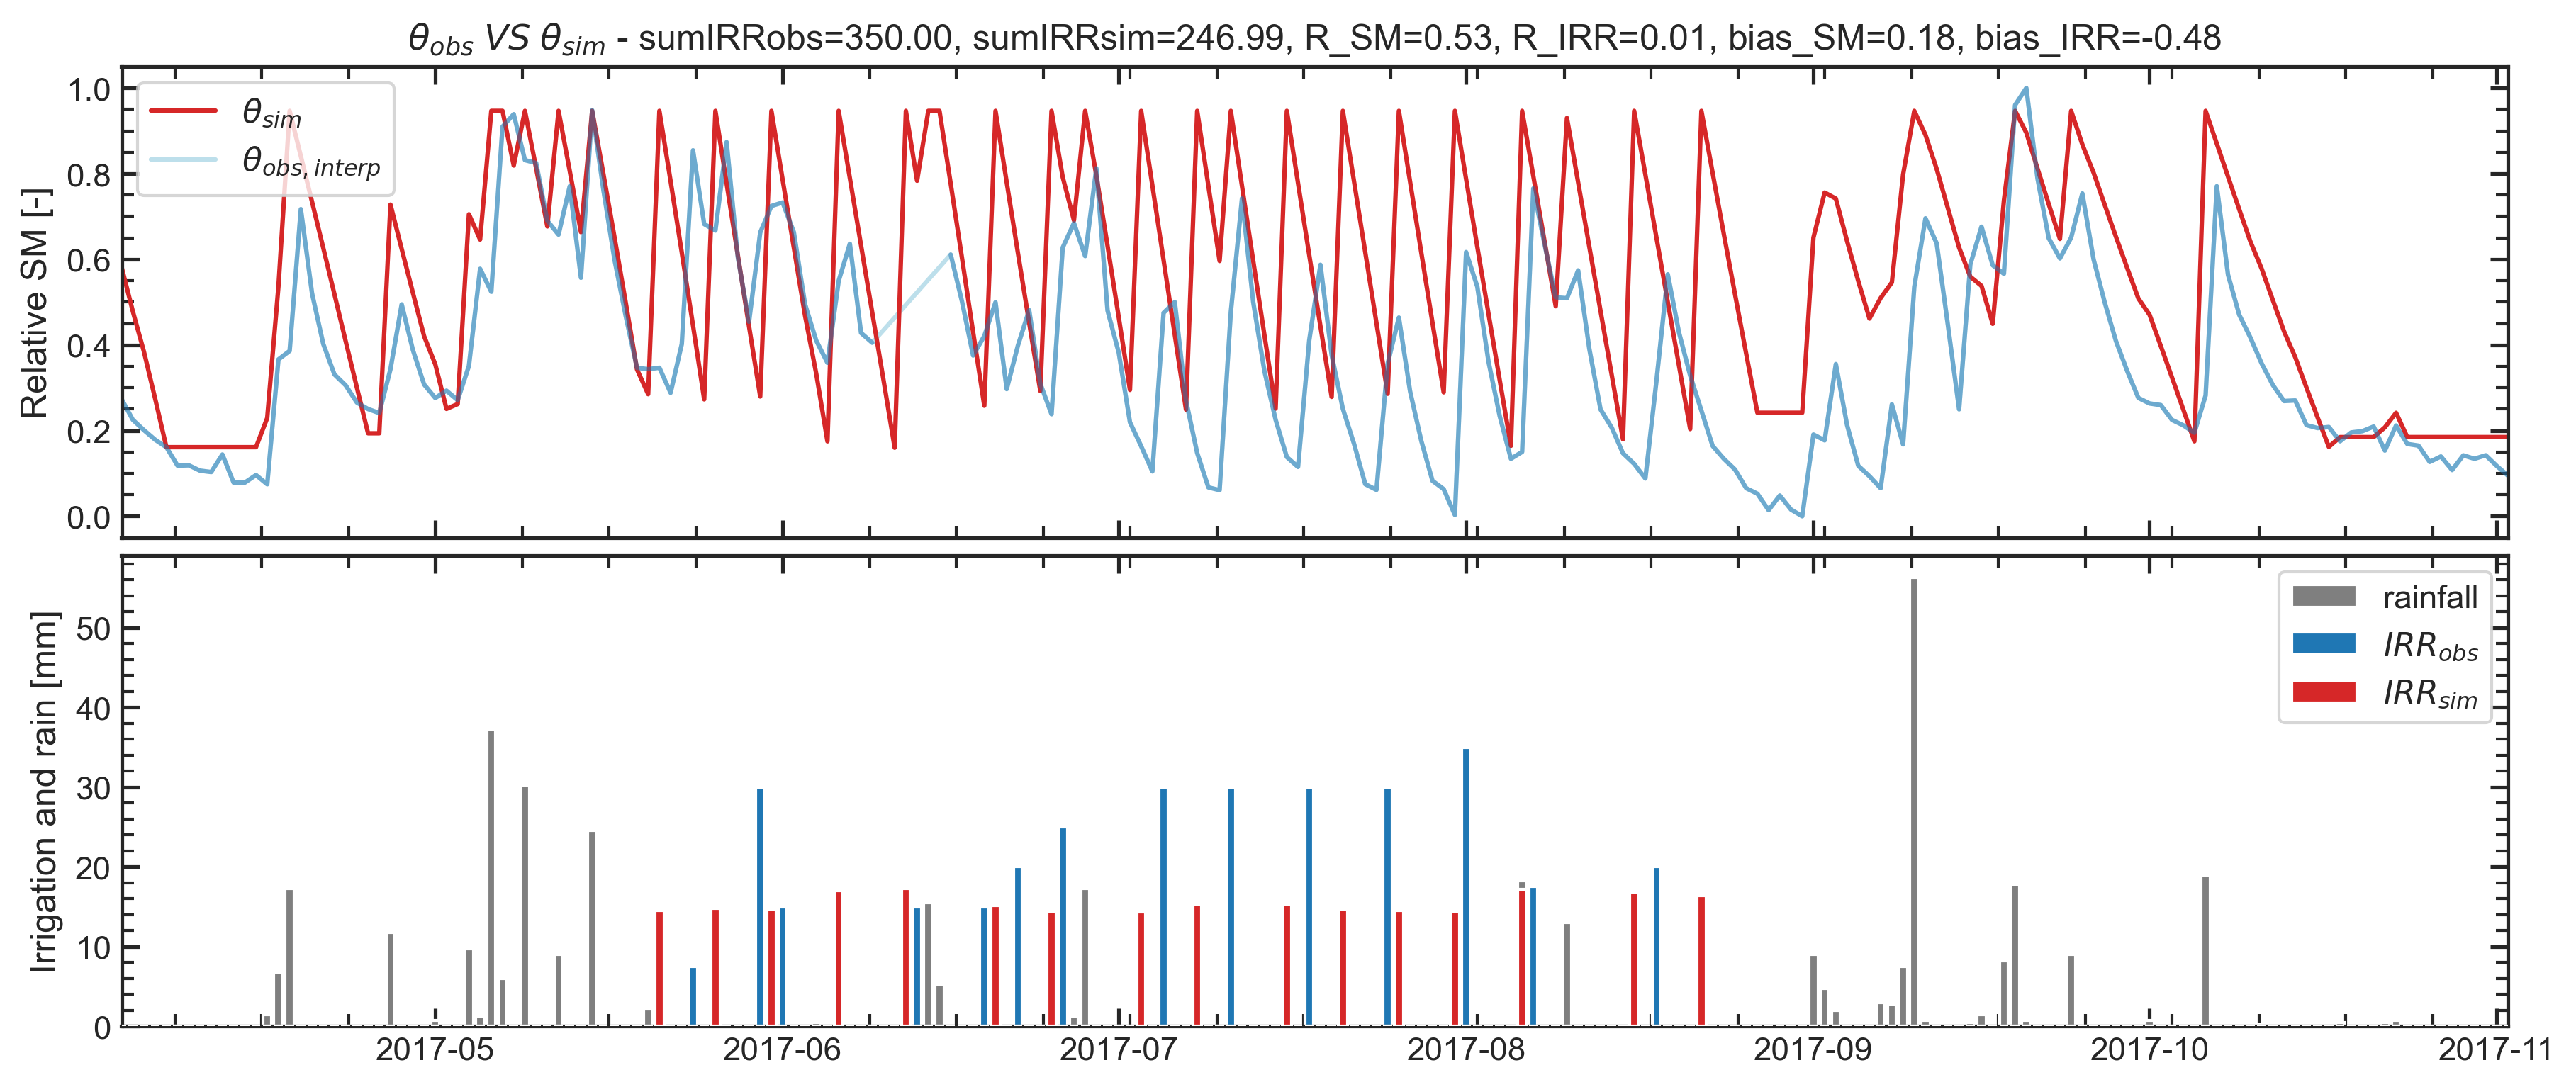

In [10]:
#-----------------------------------------------------------------------------
# Figures
#-----------------------------------------------------------------------------

#WW = WW
#WWobs = WWobs; WWobs_gap=WWobs_gap

opt_save_plot = True if input('Save simulated VS observed soil moisture? [[]/(any)]')=='' else False

#-----------------------------------------------------------------------------
# Model performance on SM and plot
#-----------------------------------------------------------------------------
RMSE=np.nanmean((WW-WWobs)**2)**0.5; print('RMSE =', RMSE)
NS=1-np.nansum((WW-WWobs)**2)/np.nansum((WWobs-np.nanmean(WWobs))**2); print('NS =', NS)
NS_radQ=1-np.nansum((np.sqrt(WW+0.00001)-np.sqrt(WWobs+0.00001))**2)/np.nansum((np.sqrt(WWobs+0.00001)-np.nanmean(np.sqrt(WWobs+0.00001)))**2)
NS_lnQ=1-np.nansum((np.log(WW+0.0001)-np.log(WWobs+0.0001))**2)/np.nansum((np.log(WWobs+0.0001)-np.nanmean(np.log(WWobs+0.0001)))**2)
NS_lnQ=NS_lnQ.real; # print(NS_lnQ) 
NS_radQ=NS_radQ.real; # print(NS_radQ)

# R coefficient score
WWmatrix = np.array( [ [WW[i], WWobs[i]] for i in range(len(WW)) if not np.isnan(WWobs[i]) ] )
R=np.corrcoef(WWmatrix,rowvar=False)[0][1]; print('R (WW vs WWobs) =', R)
B=bias(np.array([e[0] for e in WWmatrix]), np.array([e[1] for e in WWmatrix]))
IRRmatrix = np.array( [ [IRR[i], IRRobs[i]] for i in range(len(IRR)) if not np.isnan(IRRobs[i]) ] )
R_IRR=np.corrcoef(IRRmatrix,rowvar=False)[0][1]; print('R_IRR (IRR vs IRRobs)=', R_IRR)
B_IRR=bias(np.array([e[0] for e in IRRmatrix]), np.array([e[1] for e in IRRmatrix]))

fig, ax = plt.subplots(2, 1,constrained_layout=True,figsize=(12, 5), sharex=True,dpi=300,)

title=r'$\theta_{obs}\;VS\;\theta_{sim}$ - '+\
    f'sumIRRobs={np.sum(IRRobs):.2f}, '+\
    f'sumIRRsim={np.sum(IRR):.2f}, '+\
    f'R_SM={R:.2f}, R_IRR={R_IRR:.2f}, '+\
    f'bias_SM={B:.2f}, bias_IRR={B_IRR:.2f}'

ax[0].set_xlim(xmin=d[0], xmax=d[len(d)-1])

ax[0].plot(d, WW, c='tab:red', label=r'$\theta_{sim}$')

#ax[0].plot(d, norm_fit(WWobs,S_w,S_fc), c='lightblue', label=r'$\theta_{obs,interp}$',linestyle='-', alpha=.8, zorder=-1)
#WWobs_gap_norm=S_w+(WWobs_gap-np.min(WWobs))*(S_fc-S_w)/(np.max(WWobs)-np.min(WWobs))
#ax[0].plot(d, WWobs_gap_norm, c='tab:blue', alpha=.5, zorder=2)

ax[0].plot(d, WWobs, c='lightblue', label=r'$\theta_{obs,interp}$',linestyle='-', alpha=.8, zorder=-1)
ax[0].plot(d, WWobs_gap, c='tab:blue', alpha=.5, zorder=2)
ax[0].legend(loc='upper left')
ax[0].set_title(title)
ax[0].set_ylabel('Relative SM [-]')

ax[1].bar(d, P, color='tab:gray', label=r'rainfall')
ax[1].bar(d, IRRobs, color='tab:blue', label=r'$IRR_{obs}$', zorder=2)
ax[1].bar(d, IRR, color='tab:red', label=r'$IRR_{sim}$', zorder=3)
ax[1].legend(loc='upper right')
ax[1].set_ylabel('Irrigation and rain [mm]')

name=''
if opt_save_plot==True:
    optim_choice = 'glo' if (optim=='')or(optim=='global') else 'local'
    name = filename+timestr+f'_{n_particles}_{n_step}_{optim_choice}_{norma}'
    plt.savefig('Plot\\'+name+'.png')
    plt.show()
    plt.close()
    cost_history = optimizer.cost_history
    plot_cost_history(cost_history)
    plt.savefig('Plot\\'+name+'_cost'+'.png')

In [14]:
from IPython.display import Image as Image
from pyswarms.utils.functions.single_obj import sphere
from pyswarms.utils.plotters.formatters import Mesher
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
from pyswarms.backend.handlers import OptionsHandler

# Initialize mesher with sphere function
m = Mesher(func=fx.sphere)

In [32]:
pos = optimizer.pos_history; pos[0][:2]

array([[ 5.87010381e-01,  8.12179204e-01, -1.31008942e+01,
         8.63982973e+00,  8.29948884e-01,  2.72438352e+02,
         9.09999181e-02,  3.29892104e-02,  5.20899061e-01,
         4.87604326e-01],
       [ 8.67591414e-01,  9.41036662e-01, -5.35262130e+00,
         7.29892787e+00,  6.93264615e-01,  1.98932907e+02,
         2.59320324e-01,  2.08752689e-01,  5.18420845e-01,
         4.32072143e-01]])

In [ ]:
# pos: pos[n step][n particle][n coordinate]
# i need 0,1 coo, all particles, all n steps

In [52]:
pos_coo01 = np.array([ [ [e[0],e[1]] for e in run ] for run in pos ])
pos_coo23 = np.array([ [ [e[2],e[3]] for e in run ] for run in pos ])
pos_coo45 = np.array([ [ [e[4],e[5]] for e in run ] for run in pos ])
pos_coo67 = np.array([ [ [e[6],e[7]] for e in run ] for run in pos ])
pos_coo89 = np.array([ [ [e[8],e[9]] for e in run ] for run in pos ])

In [60]:
pos_coo = np.vstack((pos_coo01,
                     pos_coo23,
                     pos_coo45,
                     pos_coo67,
                     pos_coo89))
# pos_coo[0] = pos_coo01

In [ ]:
# %%capture
# Make animation
fig = plt.figure()
plt.xlim(-2,2); plt.ylim(-2,2)
animation = plot_contour(pos_history=pos_coo01, canvas=fig)
animation.save(f'plot_{0}'+'.gif', writer='imagemagick', fps=10)
Image(url=f'plot_{0}'+'.gif')

### Scatter

In [ ]:
def linear(x,a,b):
    return a+b*x

x = WW; y = WWobs
title = r'Observed SM VS simulated - '
xlabel = r'$\theta$ simul (SMI) [-]'
ylabel = r'$\theta$ observed [-]'
filename = 'scatter_sim-vs-obs_SM'
save_choice = input(f'Save file? (Filename is {filename}.png) [y/n]')

plt.figure(figsize=(6,6), dpi=200)
plt.plot(x, y, marker='o', linestyle='', color='tab:blue')

# Fit
popt, pcov = curve_fit(linear, x, y)
plt.plot(x, linear(np.array(x),*popt), color='tab:orange')
R=np.corrcoef(x,y)[0][1]; print('R=', R, 'R^2=', R**2)
B=bias(x,y)
OUT=he.evaluator(he.kge, x, y)
KGE=OUT[0,:]; print(KGE)

plt.xlabel(xlabel); plt.ylabel(ylabel)
#plt.xlim(0,1); plt.ylim(0,1)
xtext=0.8*(np.max(x)-np.min(x))+np.min(x)  ; ytext=0.1*(np.max(y)-np.min(y))+np.min(y)
t = plt.text(xtext, ytext,
             f'y={popt[0]:.2f}+{popt[1]:.2f}x\n'+
             r'$R^2$'+f'={R**2:.2f}',
             ha="center", va="center", size=15,
             bbox=dict(boxstyle="round,pad=0.3", fc="tab:orange", ec="k", lw=2, alpha=.5))

plt.title(title+f'R={R:.2f},'+r' $R^2$'+f'={R**2:.2f}, bias={B:.2f}, KGE={float(KGE):.2f}')

if save_choice=='y': plt.savefig(filename+'.png')

In [ ]:
def linear(x,a,b):
    return a+b*x

x = IRR; y = IRRobs
title = r'Observed IRR VS simulated - '
xlabel = r'IRR simul [mm]'
ylabel = r'IRR observed [mm]'
filename = 'scatter_sim-vs-obs_IRR'
save_choice = input(f'Save file? (Filename is {filename}.png) [y/n]')

plt.figure(figsize=(6,6), dpi=200)
plt.plot(x, y, marker='o', linestyle='', color='tab:blue')

# Fit
popt, pcov = curve_fit(linear, x, y)
plt.plot(x, linear(np.array(x),*popt), color='tab:orange')
R=np.corrcoef(x,y)[0][1]; print('R=', R, 'R^2=', R**2)
B=bias(WW,WWobs)
OUT=he.evaluator(he.kge, x, y)
KGE=OUT[0,:]; print(KGE)

plt.xlabel(xlabel); plt.ylabel(ylabel)
#plt.xlim(0,1); plt.ylim(0,1)
xtext=0.8*(np.max(x)-np.min(x))+np.min(x)  ; ytext=0.1*(np.max(y)-np.min(y))+np.min(y)
t = plt.text(xtext, ytext,
             f'y={popt[0]:.2f}+{popt[1]:.2f}x\n'+
             r'$R^2$'+f'={R**2:.2f}',
             ha="center", va="center", size=15,
             bbox=dict(boxstyle="round,pad=0.3", fc="tab:orange", ec="k", lw=2, alpha=.5))

plt.title(title+f'R={R:.2f},'+r' $R^2$'+f'={R**2:.2f}, bias={B:.2f}, KGE={float(KGE):.2f}')

if save_choice=='y': plt.savefig(filename+'.png')

In [ ]:
def linear(x,a,b):
    return a+b*x

x = sigma0; y = obs
title = r'Observed $\sigma^0$ VS simulated - '
xlabel = r'$\sigma^0$ simul [dB]'
ylabel = r'$\sigma^0$ observed [dB]'
filename = 'scatter_sim-vs-obs_sigma0'
save_choice = input(f'Save file? (Filename is {filename}.png) [y/n]')

plt.figure(figsize=(6,6), dpi=200)
plt.plot(x, y, marker='o', linestyle='', color='tab:blue')

# Fit
popt, pcov = curve_fit(linear, x, y)
plt.plot(x, linear(np.array(x),*popt), color='tab:orange')
R=np.corrcoef(x,y)[0][1]; print('R=', R, 'R^2=', R**2)
B=bias(WW,WWobs)
OUT=he.evaluator(he.kge, x, y)
KGE=OUT[0,:]; print(KGE)

plt.xlabel(xlabel); plt.ylabel(ylabel)
#plt.xlim(0,1); plt.ylim(0,1)
xtext=0.8*(np.max(x)-np.min(x))+np.min(x)  ; ytext=0.1*(np.max(y)-np.min(y))+np.min(y)
t = plt.text(xtext, ytext,
             f'y={popt[0]:.2f}+{popt[1]:.2f}x\n'+
             r'$R^2$'+f'={R**2:.2f}',
             ha="center", va="center", size=15,
             bbox=dict(boxstyle="round,pad=0.3", fc="tab:orange", ec="k", lw=2, alpha=.5))

plt.title(title+f'R={R:.2f},'+r' $R^2$'+f'={R**2:.2f}, bias={B:.2f}, KGE={float(KGE):.2f}')

if save_choice=='y': plt.savefig(filename+'.png')

In [ ]:
opt_save_plot = True if input('Save simulated VS observed soil moisture? [[]/(any)]')=='' else False

#-----------------------------------------------------------------------------
# Model performance on sigma0 and plot
#-----------------------------------------------------------------------------
q1 = sigma0; q2 = obs; times = d_sat
label1 = r'$\sigma^0_{sim}$'; label2=r'$\sigma^0_{obs}$'; labely=r'$\sigma^0$[dB]'
marker='o'; linestyle='-'

# NS=1-np.nansum((q1-q2)**2)/np.nansum((q2-np.nanmean(q2))**2)
# NS_radQ=1-np.nansum((np.sqrt(q1+0.00001)-np.sqrt(q2+0.00001))**2)/np.nansum((np.sqrt(q2+0.00001)-np.nanmean(np.sqrt(q2+0.00001)))**2)
# NS_lnQ=1-np.nansum((np.log(q1+0.0001)-np.log(q2+0.0001))**2)/np.nansum((np.log(q2+0.0001)-np.nanmean(np.log(q2+0.0001)))**2)
# NS_lnQ=NS_lnQ.real; # print(NS_lnQ) 
# NS_radQ=NS_radQ.real; # print(NS_radQ)

RMSE=np.mean((q1-q2)**2)**0.5; print('RMSE =', RMSE)
R=np.corrcoef(q1,q2)[0][1]; print('R=', R)
B=bias(q1,q2); print('bias =', B)

fig, ax = plt.subplots(3, 1,constrained_layout=True,figsize=(12, 7), sharex=True,dpi=300,)

title=f'{label1} VS {label2} - R={R:.2f}, bias={B:.2f}'

ax[0].set_xlim(xmin=times[0], xmax=times[len(times)-1])
ax[0].plot(times, q1, c='tab:red', label=label1,
           linestyle=linestyle, marker=marker, )#alpha=.4, zorder=-1)
ax[0].plot(times, q2, c='tab:blue', label=label2,
           linestyle=linestyle, marker=marker, alpha=.4, zorder=-1)
ax[0].legend(loc='upper right')
ax[0].set_title(title)
ax[0].set_ylabel(labely)

ax[1].bar(d, P, color='tab:gray', label=r'rainfall')
ax[1].bar(d, IRRobs, color='tab:blue', label=r'$IRR_{obs}$', zorder=2)
ax[1].bar(d, IRR, color='tab:red', label=r'$IRR_{sim}$', zorder=3)
ax[1].legend(loc='upper right')
ax[1].set_ylabel('Irrigation and rain [mm]')

ax[2].plot(times, NDVI, label='NDVI [-]', color='tab:olive')
ax[2].legend(loc='upper right')
ax[2].set_ylabel('NDVI [-]')

name=''
if opt_save_plot==True:
    optim_choice = 'glo' if (optim=='')or(optim=='global') else 'local'
    name = filename+timestr+f'_{n_particles}_{n_step}_{optim_choice}_{norma}'
    plt.savefig('Plot\\'+name+'sigma0.png')